In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from jupyterplot import ProgressPlot

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets as D
from torchvision import transforms as T

from utils import invest_size
from utils import sample_random_data
from utils import show_images
from utils import train_step, test_step

# CIFAR10에서 직접 만든 모델 훈련해보기
#### 힌트
- Convolution layer 늘리기: input / output feature의 크기가 같도록 하면 늘릴 수 있음
- Convolution layer의 out_channels 조절해보기
- Fully connected layer(nn.Linear)의 features 조절해보기

In [ ]:
class ConvolutionNeuralNetworks(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=16,
            kernel_size=3, stride=1, padding=1
        )
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(in_features=64 * 4 * 4, out_features=64)
        self.fc2 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        
        x = x.flatten(start_dim=1)
        
        x = self.fc1(x)
        x = self.fc2(x)
        return x
cnn = ConvolutionNeuralNetworks()
print(cnn)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = 30
batch_size = 128
learning_rate = 0.01

# CIFAR10 데이터셋

Files already downloaded and verified
Files already downloaded and verified


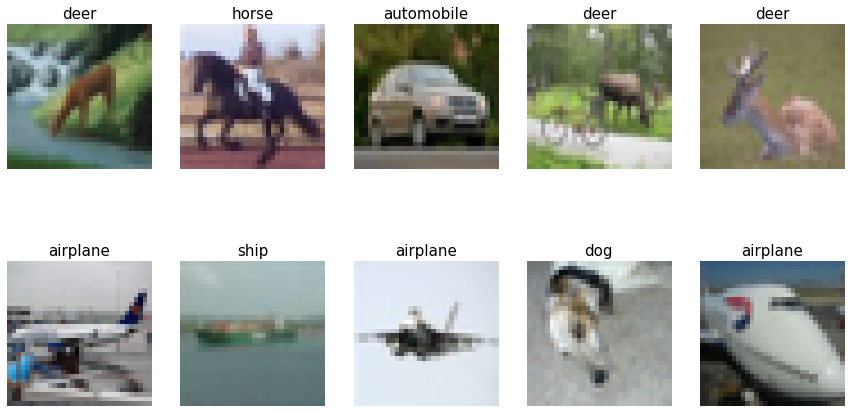

In [11]:
phases = ['train', 'test']
transform = T.Compose([T.Resize((32, 32)), T.ToTensor()])
cifar10_dataset = {
    phase: D.CIFAR10(
        'data', train=phase=='train', transform=transform, download=True
    )
    for phase in phases
}
loader = {
    phase: DataLoader(
        cifar10_dataset[phase],
        batch_size=batch_size
    )
    for phase in ['train', 'test']
}
images, target = sample_random_data(cifar10_dataset['train'])
titles = [cifar10_dataset['train'].classes[idx] for idx in target]
show_images(images.permute(0,2,3,1), titles)

In [ ]:
cnn = ConvolutionNeuralNetworks().to(device)
optimizer = torch.optim.SGD(cnn.parameters(), learning_rate, 0.9)
criterion = nn.CrossEntropyLoss()

pp = ProgressPlot(
    plot_names=phases,
    line_names=['loss', 'accuracy'],
    x_lim=[0, num_epochs*len(loader['train'])],
    x_label='Iteration',
    y_lim=[[0, 2], [0, 100]]
)

accuracy = 0
for epoch in range(num_epochs):
    for inputs, target in loader['train']:
        loss = train_step(cnn, inputs, target, optimizer, criterion, device)
        pp.update([[loss, -1], [-500, accuracy]])
    
    corrects = 0
    for inputs, target in loader['test']:
        output, _ = test_step(cnn, inputs, target, device=device)
        corrects += (output.argmax(1).cpu() == target).sum().item()
    accuracy = corrects / len(cifar10_dataset['test']) * 100
    
    print(f'Epoch: {epoch+1} accuracy {accuracy:.2f}')

In [ ]:
images, targets = sample_random_data(cifar10_dataset['test'], num=25)
scores = cnn(images.to(device))
predicted = scores.argmax(1).detach().cpu()
correctness = (predicted == torch.as_tensor(targets))

target_names = [cifar10_dataset['test'].classes[t] for t in targets]
pred_names = [cifar10_dataset['test'].classes[t] for t in predicted]
titles = [f'target {t}\npredicted as {p}\n{"correct" if c else "WRONG"}'
          for t, p, c in zip(target_names, pred_names, correctness)]
show_images(images.permute(0,2,3,1), titles)